In [1]:
# Load libraries
import pandas
import numpy as np
import statsmodels.api as sm
from patsy import dmatrices
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

C:\Users\Randhawa\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Load dataset
dataset = pandas.read_csv('FinalData.csv')

Data Transformations

In [5]:
#These values do not affect what we are predicting (not even referee in my opinion) so we will delete them
del dataset['ID']
del dataset['Date']
del dataset['Referee']

In [6]:
#These are neither getting predicted or providing prior knowledge
del dataset['HTHG']
del dataset['HTAG']
del dataset['HTR-A']
del dataset['HTR-D']
del dataset['HTR-H']

In [7]:
#normalisation. Dividing wins by number of games played to make it even for all teams. Can't do 0 divided by 0 so keep the same if less than 1
dataset['HHWins'] = np.where(dataset['HHGames'] < 1, dataset['HHWins'], dataset['HHWins']/dataset['HHGames'])
dataset['AHWins'] = np.where(dataset['AHGames'] < 1, dataset['AHWins'], dataset['AHWins']/dataset['AHGames'])
dataset['HAWins'] = np.where(dataset['HAGames'] < 1, dataset['HAWins'], dataset['HAWins']/dataset['HAGames'])
dataset['AAWins'] = np.where(dataset['AAGames'] < 1, dataset['AAWins'], dataset['AAWins']/dataset['AAGames'])

In [8]:
#Encode the strings as numericals in order for the algorithms to be able to take them
#0-Away win, 1- Draw, 2- Home Win
from sklearn.preprocessing import LabelEncoder
lbl_enc = LabelEncoder()
lbl_enc.fit(dataset.FTR)
dataset.FTR = lbl_enc.transform(dataset.FTR)
lbl_enc.fit(dataset.HomeTeam)
dataset.HomeTeam = lbl_enc.transform(dataset.HomeTeam)
lbl_enc.fit(dataset.AwayTeam)
dataset.AwayTeam = lbl_enc.transform(dataset.AwayTeam)

Data Exploration

In [9]:
dataset.groupby('FTR').mean()

,HomeTeam,AwayTeam,FTHG,FTAG,HS,AS,HST,AST,HF,AF,...,HHCorners,HAShots,HAShotsTarget,HACorners,AHShots,AHShotsTarget,AHCorners,AAShots,AAShotsTarget,AACorners
FTR,,,,,,,,,,,,,,,,,,,,,
0,10.927944,8.571178,0.602812,2.233743,12.430580,12.776801,4.797891,6.126538,11.404218,11.611599,...,5.069872,9.603560,4.189039,4.165731,9.853875,4.291985,4.242475,10.770752,4.858503,4.576006
1,9.856863,9.850980,1.001961,1.001961,13.556863,11.074510,5.845098,4.831373,11.354902,12.000000,...,5.336828,10.425229,4.679287,4.365888,10.555834,4.775979,4.483465,10.096011,4.594728,4.282331
2,9.030837,10.522026,2.346916,0.484581,14.929515,9.914097,7.429515,4.213656,10.986784,11.856828,...,5.684207,11.149861,5.150235,4.730764,10.955354,5.022493,4.648573,9.707656,4.356117,4.128744


We can see that for an away win, there are usually more away corners, shots and shots on target. So there is definitely a correlation between the team that wins and these statistics.

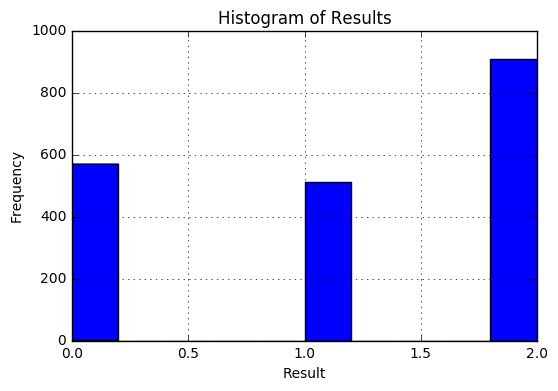

In [10]:
# show plots in the notebook
%matplotlib inline

# histogram of results
dataset["FTR"].hist()
plt.title('Histogram of Results')
plt.xlabel('Result')
plt.ylabel('Frequency')

As we can see from the histograms, a home win is nearly twice as frequent as an away win in the dataset, and home wins occur nearly as often as away wins and draws put together. This suggests the team playing at home hold some sort of advantage over the away team. So it is necessary to separate the features into home and away.

METHODOLOGY OVERVIEW

In order to gain some insight into how this problem could be approached, I initially had a look around to see how others have attempted this sort of thing in the past. I came accross a paper 'Predicting Soccer Match Results in the English Premier League' by Ben Ulmer and Matthew Fernandez, in which they used the concept of a team's 'form' to predict results. They did this by looking at a team's past 10 matches, and how many times they won in this period. This seems like a plausible method, however I did not want to ignore 15 seasons worth of data and so I decided to use the idea of form on the whole training set. I recognise that form does not crossover from season to season, as major changes take place over the summer for every team, so I decided to split the data by seasons and calculate form within each season. To calculate form, instead of only looking at the past X games, I used data from all the games to calculate cumulative totals for each team based the number of wins that season, shots, shots on target, and corners. I did not feel that fouls, yellow cards and red cards reflected the strength of a team, as some very successful teams have their game based around slowing the match down by fouling the oppostion constantly.

I had originally thought of getting all the results for every team since 2003, and also for the lower leagues and making one big file with all these matches, and thengrouping the matches by season and then by team, but I decided to stick with the matches provided in the training set. I divided the number of wins for each team by the number of games played, because some teams had not played anywhere near as many matches as other teams in the dataset, and so this was a way of evening things out.

The target variable, FTR, could have been dummy coded into different binary variables, but then predicting this would have involved multi-label classification algorithms which is still a new field of research. I decided to keep it as a categorical variable with three classes, and convert the letters into numericals, as this would make it easier to feed the dataset to algorithms. If there were many more classes, this may have caused bias issues, but three is a small enough number to make this work. i decided to go with Logistic Regression because it is perfectly suited to predicting categoric variables and performed at a higher accuracy than other algorithms I tested such as decision forests. I split the dataset into a 70 percent to 30 percent ratio for training to test sets, because I found this prevents overfitting of the data, which would cause classifier bias.





Model Training

In [11]:
# Get all the columns from the dataframe.
columns = dataset.columns.tolist()
# Filter the columns to remove ones we don't want.
columns = [c for c in columns if c not in ["Season","FTHG", "FTAG", "FTR", "HS", "AS", "HST", "HST", "AST", "HF", "AF", "HC", "AC", "HY", "AY", "HR", "AR", "AS"]]

# Store the variable we'll be predicting on.
target = "FTR"

In [12]:
# Generate the training set.  Set random_state to be able to replicate results. 0.7 to not overfit data.
train = dataset.sample(frac=0.7, random_state=1)
# Select anything not in the training set and put it in the testing set.
test = dataset.loc[~dataset.index.isin(train.index)]
# Print the shapes of both sets.
print(train.shape)
print(test.shape)

(1391, 38)
(596, 38)


In [13]:
# Initialize the model class.
model = LogisticRegression()
# Fit the model to the training data.
model.fit(train[columns], train[target])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [14]:
#accuracy
model.score(train[columns], train[target])

0.52624011502516177

Our accuracy is very high at 53%,almost as good as the bookies.

In [15]:
# Import the scikit-learn function to compute error.
from sklearn.metrics import mean_squared_error
# Generate our predictions for the test set.
predictions = model.predict(test[columns])

# Compute error between our test predictions and the actual values.
mean_squared_error(predictions, test[target])

1.2332214765100671

In [16]:
#mean
train[target].mean()

1.1718188353702372

In [17]:
print(predictions)

[0 2 0 0 2 2 2 2 2 2 0 0 2 2 0 2 2 2 2 2 2 2 1 0 2 0 2 2 2 0 2 0 2 2 2 2 2
 2 2 0 2 2 2 2 2 2 2 2 2 2 0 2 0 2 0 0 2 2 0 2 2 2 2 2 0 0 2 0 0 0 0 2 2 0
 0 2 2 2 2 2 0 0 2 2 2 0 2 2 0 2 2 2 2 0 0 0 2 2 2 2 2 2 0 0 0 2 2 0 0 0 2
 2 2 2 2 2 2 2 2 2 2 2 0 2 0 2 0 2 0 2 0 0 2 0 0 2 2 2 2 2 2 0 2 2 2 2 2 0
 2 0 2 2 2 0 2 2 2 2 0 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 0
 2 0 0 2 0 2 2 2 2 2 0 2 2 0 0 2 2 2 2 2 2 0 2 0 2 2 0 0 0 2 2 2 2 2 0 2 2
 2 0 2 2 0 0 0 2 2 2 2 2 2 0 2 0 2 0 2 2 2 0 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2
 2 0 2 0 1 2 0 2 2 2 2 2 2 2 2 0 2 2 2 0 2 2 2 2 2 2 2 2 2 0 2 2 2 2 0 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 2 2 2 2 2 2 0 2 2 2 2 0 2 0 2 2 0 2 2
 2 0 2 0 1 2 2 2 2 2 0 2 0 2 2 0 2 2 2 0 0 2 2 0 2 2 2 2 0 2 0 2 2 2 2 0 2
 2 2 0 2 0 2 2 0 0 0 2 2 0 2 0 2 2 0 0 2 2 2 0 0 2 0 0 2 2 2 2 2 2 0 0 0 2
 0 0 2 2 2 2 0 0 2 2 2 0 0 2 2 2 0 0 0 2 2 2 2 2 2 0 2 0 2 0 0 0 0 2 2 0 2
 2 2 2 0 0 2 2 2 2 2 0 2 2 0 2 0 0 2 2 2 2 2 2 0 0 0 0 2 2 2 0 2 2 1 2 2 0
 2 0 0 2 2 0 2 0 2 0 0 2 

In [18]:
# generate class probabilities
probs = model.predict_proba(test[columns])
print (probs)

[[ 0.52778272  0.2370725   0.23514478]
 [ 0.15807644  0.25797846  0.5839451 ]
 [ 0.44831844  0.30265654  0.24902501]
 ..., 
 [ 0.08391621  0.18279973  0.73328406]
 [ 0.36456622  0.23456401  0.40086976]
 [ 0.21032778  0.26331502  0.5263572 ]]


As you can see, the classifier is predicting a 0 (away win) any time the probability is greater than 0.5.

In [19]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), train[columns], train[target], scoring='accuracy', cv=10)
print (scores)
print (scores.mean())

[ 0.51428571  0.54285714  0.55        0.46428571  0.43884892  0.53956835
  0.53956835  0.51798561  0.50724638  0.45255474]
0.506720091579


Using 10-fold cross-validation, the accuracy of 53% still holds, which is a good sign.


Results and Prediction for weekend fixtures

In [26]:
# Load test dataset
testset = pandas.read_csv('TestEPLData.csv')

In [27]:
#Do all the same transformation
del testset['ID']
del testset['Date']
del testset['Referee']
del testset['HTHG']
del testset['HTAG']
del testset['HTR-A']
del testset['HTR-D']
del testset['HTR-H']
del testset['FTHG']
del testset['FTAG']
del testset['HS']
del testset['AS']
del testset['HST']
del testset['AST']
del testset['HF']
del testset['AF']
del testset['HC']
del testset['AC']
del testset['HY']
del testset['AY']
del testset['HR']
del testset['AR']

from sklearn.preprocessing import LabelEncoder
testset['HHWins'] = np.where(testset['HHGames'] < 1, testset['HHWins'], testset['HHWins']/testset['HHGames'])
testset['AHWins'] = np.where(testset['AHGames'] < 1, testset['AHWins'], testset['AHWins']/testset['AHGames'])
testset['HAWins'] = np.where(testset['HAGames'] < 1, testset['HAWins'], testset['HAWins']/testset['HAGames'])
testset['AAWins'] = np.where(testset['AAGames'] < 1, testset['AAWins'], testset['AAWins']/testset['AAGames'])
lbl_enc = LabelEncoder()
lbl_enc.fit(testset.FTR)
testset.FTR = lbl_enc.transform(testset.FTR)
lbl_enc.fit(testset.HomeTeam)

LabelEncoder()

In [28]:
testset

,HomeTeam,AwayTeam,FTR,Season,HHGames,HAGames,AAGames,AHGames,HHWins,AHWins,...,HHCorners,HAShots,HAShotsTarget,HACorners,AHShots,AHShotsTarget,AHCorners,AAShots,AAShotsTarget,AACorners
0,8,15,0,2016-2017,2,5,4,4,1.00,0.50,...,10.126185,17.283367,5.469031,8.212262,9.115458,3.210376,3.081837,12.192212,5.394159,4.929675
1,1,17,0,2016-2017,4,4,4,4,0.75,0.50,...,5.566333,9.691024,2.447625,4.970323,14.242259,5.998860,3.610158,6.690125,2.872768,5.313723
2,4,5,0,2016-2017,4,4,4,4,0.25,0.25,...,7.501354,11.991029,2.612860,7.385992,13.624285,4.635256,8.654320,8.048362,3.461584,2.060494
3,11,19,0,2016-2017,4,4,4,4,0.00,0.00,...,4.446224,8.282644,2.349026,4.103347,17.548431,2.096058,4.031079,12.970043,3.799455,5.209236
4,13,10,0,2016-2017,4,4,3,4,0.25,0.00,...,6.641144,8.345680,4.462204,2.934759,20.026353,7.432527,9.990788,17.261448,4.149488,6.069197
5,18,14,0,2016-2017,4,4,4,4,0.25,0.25,...,4.692164,14.533070,5.222151,5.276757,9.375095,2.658002,5.558000,8.915716,1.515408,3.826328
6,9,16,0,2016-2017,4,4,4,4,0.75,1.00,...,10.120587,13.838605,5.655460,4.241193,16.563944,6.733074,6.483788,19.096320,7.065241,8.135566
7,0,2,0,2016-2017,4,4,3,5,0.75,0.40,...,5.823245,17.437872,4.674764,5.223290,10.113379,1.829122,3.414344,6.203114,1.057577,3.536195
8,3,6,0,2016-2017,4,4,4,4,0.75,0.50,...,7.685137,19.625089,7.003345,6.294061,8.282382,2.902540,3.946533,9.554056,3.349026,4.221793
9,12,7,0,2016-2017,4,4,4,4,0.50,0.25,...,7.216262,12.414855,5.271132,4.012176,10.293520,2.532171,3.718757,8.158832,1.441738,5.231624


In [29]:
testset.columns

Index(['HomeTeam', 'AwayTeam', 'FTR', 'Season', 'HHGames', 'HAGames',
       'AAGames', 'AHGames', 'HHWins', 'AHWins', 'AAWins', 'HAWins', 'HHShots',
       'HHShotsTarget', 'HHCorners', 'HAShots', 'HAShotsTarget', 'HACorners',
       'AHShots', 'AHShotsTarget', 'AHCorners', 'AAShots', 'AAShotsTarget',
       'AACorners'],
      dtype='object')

In [30]:
# Get all the columns from the dataframe.
columns2 = testset.columns.tolist()
# Filter the columns to remove ones we don't want.
columns2 = [c for c in columns if c not in ["Season"]]

# Store the variable we'll be predicting on.
target2 = "FTR"

In [31]:
# Generate our predictions for the test set.
predictions2 = model.predict(testset[columns2])

In [32]:
predictions2

array([2, 2, 2, 0, 0, 2, 2, 2, 2, 2], dtype=int64)

0 = A, 2 = H
So the predictions are [H, H, H, A, A, H, H, H, H, H]

    Date	HomeTeam	    AwayTeam     Result
21/01/2017	Liverpool	    Swansea      H
21/01/2017	Bournemouth	    Watford      H
21/01/2017	Crystal Palace	Everton      H
21/01/2017	Middlesbrough	West Ham     A
21/01/2017	Stoke	        Man United   A
21/01/2017	West Brom	    Sunderland   H
21/01/2017	Man City	    Tottenham    H
22/01/2017	Arsenal	        Burnley      H
22/01/2017	Chelsea	        Hull         H
22/01/2017	Southampton	    Leicester    H

